MouseNet

In [13]:
import os
import sys
sys.path.append('../')
sys.path.append('../cmouse/')
sys.path.append('../mouse_cnn/')
%matplotlib inline

import torch

In [1]:
# pick a directory for auxiliary data and files needed for the connectivity
DATA_DIR = '../data' 

need allensdk, mouse_connectivity_models

Construct the network architecture using the mouse anatomy

In [2]:
from anatomy import gen_anatomy
from architecture import Architecture

In [3]:
architecture = Architecture(data_folder=DATA_DIR)
anet = gen_anatomy(architecture)

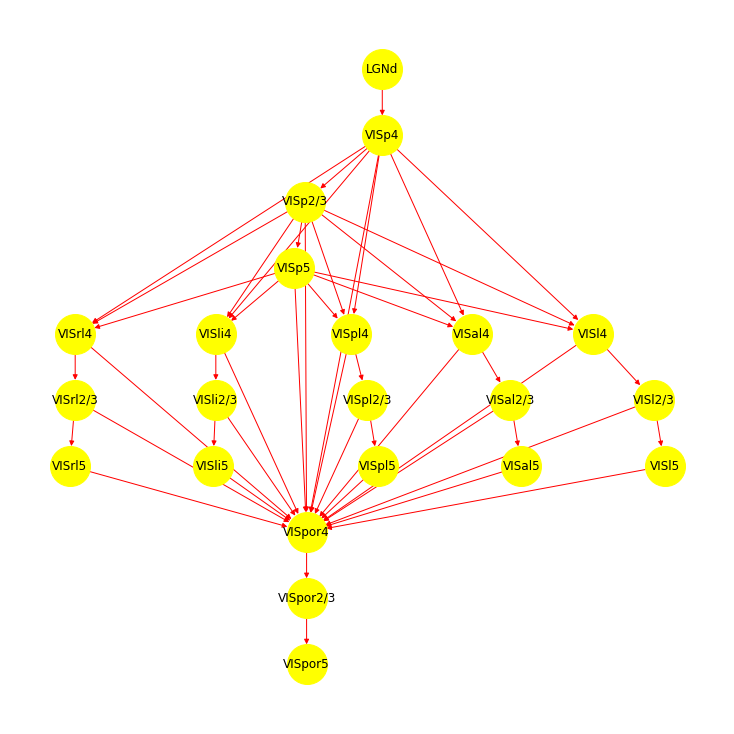

In [4]:
anet.draw_graph()

Generate kernel parameters from hit rate, cell count, etc. data

In [5]:
import network
net = network.Network()
net.construct_from_anatomy(anet, architecture)

constructing layer 0: LGNd to VISp4
constructing layer 1: VISp4 to VISp2/3
constructing layer 2: VISp4 to VISl4
kernel width: 0.3131697503325772 mm, 9.730945856276085 pixels
VISp4->VISl4: dw=9.730945856276085, dp=0.02970680822786065
kernel width: 0.3131697503325772 mm, 9.730945856276085 pixels
constructing layer 3: VISp4 to VISrl4
kernel width: 0.30668812414515495 mm, 9.529545965566825 pixels
VISp4->VISrl4: dw=9.529545965566825, dp=0.03198106713786493
kernel width: 0.30668812414515495 mm, 9.529545965566825 pixels
constructing layer 4: VISp4 to VISli4
kernel width: 0.296680275206218 mm, 9.21857775724158 pixels
VISp4->VISli4: dw=9.21857775724158, dp=0.03188358661030729
kernel width: 0.296680275206218 mm, 9.21857775724158 pixels
constructing layer 5: VISp4 to VISpl4
kernel width: 0.2906250142078913 mm, 9.030426069992853 pixels
VISp4->VISpl4: dw=9.030426069992853, dp=0.032135598575926634
kernel width: 0.2906250142078913 mm, 9.030426069992853 pixels
constructing layer 6: VISp4 to VISal4
ker

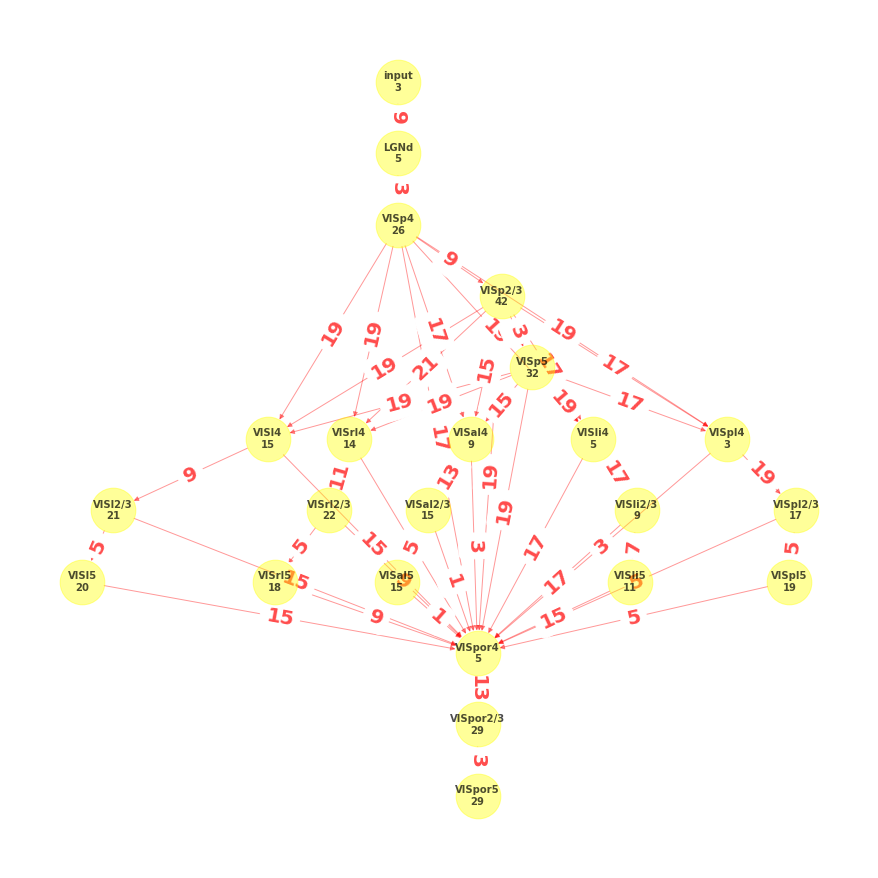

In [6]:
net.draw_graph()

In [7]:
network.save_network_to_pickle(net, 'network_complete_updated_number(3,64,64).pkl')

In [16]:
# we have to load the following weights because of a bug fix in progress
net = network.load_network_from_pickle('../cmouse/exps/imagenet/myresults/network_complete_updated_number(3,64,64).pkl')

import the object that defines the pytorch model using the created network

In [17]:
import mousenet_complete_pool

In [18]:
mousenet = mousenet_complete_pool.MouseNetCompletePool(net)

The mousenet object is a pytorch model object whose forward method will return the ImageNet class chosen under the model.  This model can be trained with a standard train loop as would be done with any pytorch model.  

Scripts that train MouseNet on cifar and ImageNet can be found in the GitHub repo.

In [31]:
# Example train loop (the basic loop from the training scripts in the GitHub repo)

# import torch.optim as optim

# mousenet.to(device)

# optimizer = optim.SGD(mousenet.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=5e-4)
# for data, target in train_loader:
#       data, target = data.to(device), target.to(device)
#       optimzier.zero_grad()
#       output=mousenet(data)
#       loss = torch.nn.functional.cross_entropy(output, target)
#       loss.backward()
#       optimizer.step()


For now we will load pretrained weights from ImageNet classification training.  This is done in the standard way under pytorch.

In [24]:
f = torch.load('../cmouse/exps/imagenet/1111_model_best.pth.tar', map_location='cpu')
mousenet.load_state_dict(f['state_dict'])
best_acc1 = f['best_acc1']

In [25]:
# Generate random input
# 10 3-channel images of shape 64,64
x = torch.rand(10,3,64,64)

Features from individual layers can be computed with the `get_img_feature` method, which takes the input (a torch tensor) and a list of areas as arguments.

In [26]:
mousenet.get_img_feature(x, ['VISp4'])

tensor([[0.9578, 0.0000, 2.6605,  ..., 0.8625, 1.1061, 0.4588],
        [0.0000, 0.0260, 0.0000,  ..., 0.7713, 0.0000, 0.8771],
        [0.0000, 0.9739, 0.0000,  ..., 0.5602, 0.0000, 0.8723],
        ...,
        [0.7937, 0.0000, 0.0000,  ..., 0.0302, 0.0000, 1.4334],
        [0.3094, 0.0000, 1.2403,  ..., 0.0000, 0.0000, 1.2229],
        [0.0000, 0.0000, 1.4696,  ..., 0.5155, 0.0000, 0.7060]],
       grad_fn=<ViewBackward>)

If you request more than one area, the output for each area will be downsampled to 4x4 and then concatenated, so if you require the full output of each area, they should be computed one at a time.

In [27]:
OUTPUT_AREAS = ['VISp5', 'VISl5', 'VISrl5', 'VISli5', 'VISpl5', 'VISal5', 'VISpor5']

mousenet.get_img_feature(x, OUTPUT_AREAS)

tensor([[0.3281, 0.2948, 0.4538,  ..., 0.5602, 0.5414, 0.8233],
        [1.7981, 0.6842, 0.7010,  ..., 0.7929, 0.6605, 0.7622],
        [1.4615, 0.4048, 0.9075,  ..., 0.7088, 0.6660, 0.7212],
        ...,
        [0.8223, 0.2482, 0.6707,  ..., 0.5976, 0.7483, 0.7641],
        [1.3002, 1.9642, 0.2342,  ..., 0.7053, 0.7734, 0.7310],
        [0.5748, 0.6061, 1.1234,  ..., 0.7592, 0.8460, 0.8200]],
       grad_fn=<CatBackward>)